In [19]:
import xarray
import matplotlib.pyplot as mp
import cartopy
import numpy
import glob
import gdal
import matplotlib.colors
import geopandas
import shapely
import cmocean
import pandas
import joblib
import datetime
import scipy
import scipy.stats

In [20]:
et_npy_file_list = sorted(glob.glob('CAL_LID_L2_05kmCPro-Standard-V4-10*'))

In [91]:
# open first collection
f = 3
et_file_list = numpy.load(et_npy_file_list[f])

In [92]:
et_file_list[0]

'/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/CAL_LID_L2_05kmCPro-Standard-V4-10.2006-06-15T17-53-35ZN.hdf'

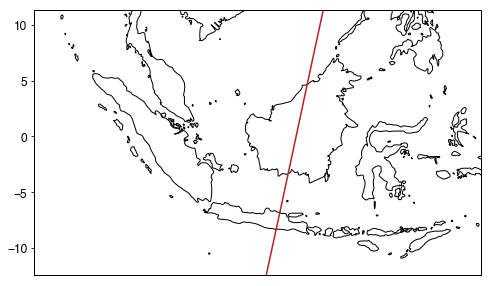

In [94]:
ds = xarray.open_dataset(et_file_list[0])

lat = ds['Latitude'].sel(fakeDim3=1).values
lon = ds['Longitude'].sel(fakeDim5=1).values


#####
fontsize=12
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([90,130,-12,11])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

ax.plot(lon,lat,c='firebrick')

ax.set_yticks([-10,-5,0,5,10])
ax.tick_params(labelsize=fontsize)

plot multiple at once

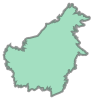

In [95]:
states = geopandas.read_file('/beegfs/DATA/pritchard/blangenb/NATURAL_EARTH_DATA/ne_10m_admin_1_states_provinces')
states_indo = states[states['admin']=='Indonesia']

# extract Kalimantan (Indonesian Borneo)
kali_indices = ['Kalimantan' in i for i in states_indo['name']]
states_indo_kalimantan = states_indo[kali_indices]

# also extract Malaysian Borneo
states_malay = states[states['admin']=='Malaysia']
states_malay_borneo = states_malay[[n in ['Sabah','Sarawak'] for n in states_malay['name']]]
states_brunei = states[states['admin']=='Brunei']

borneo_gdf = pandas.concat([states_indo_kalimantan, states_malay_borneo, states_brunei])
borneo_gdf_union = borneo_gdf.geometry.unary_union
borneo_main_geom = borneo_gdf_union.geoms[15]

list(borneo_gdf_union.geoms)[15]

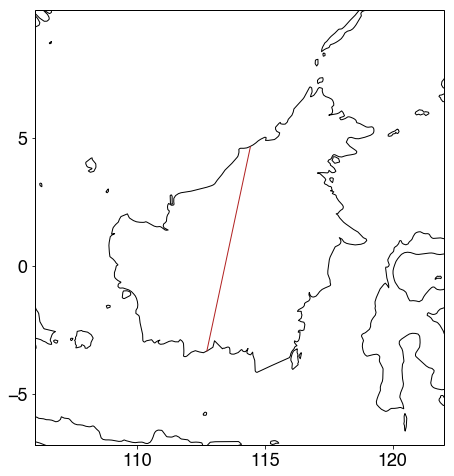

In [96]:
fontsize=18
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([106,122,-7,10])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

track_geom_crop_list = []
for file in [et_file_list[0]]:
    ds = xarray.open_dataset(file)
    lat = ds['Latitude'].sel(fakeDim3=1).values
    lon = ds['Longitude'].sel(fakeDim5=1).values
    ds.close()
    
    track_geom = shapely.geometry.LineString(zip(lon,lat))
    track_geom_crop = track_geom.intersection(borneo_main_geom)
    
    track_geom_crop_list.append(track_geom_crop)
    
    if type(track_geom_crop)!='list':
        ax.add_geometries([track_geom_crop], crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='firebrick')
    else:
        ax.add_geometries(track_geom_crop, crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='firebrick')

ax.set_yticks([-5,0,5])
ax.set_xticks([110,115,120])
ax.tick_params(labelsize=fontsize)

In [97]:
#print(track_geom_crop)
print(type(track_geom_crop))
#print(type(track_geom_crop[0]) == shapely.geometry.multilinestring.MultiLineString)

<class 'shapely.geometry.linestring.LineString'>


In [99]:
#for file in [et_file_list[0]]:
file = et_file_list[53]
ds = xarray.open_dataset(file)

lon = ds['Longitude'].sel(fakeDim5=1).values
lat = ds['Latitude'].sel(fakeDim3=1).values
p_data = ds['Pressure'].values

track_geom = shapely.geometry.LineString(zip(lon,lat))
track_geom_crop = track_geom.intersection(borneo_main_geom)

ds.close()

# open stuff in gdal to get proper values...
gdal_file = gdal.Open(file)
gdal_subdatasets = gdal_file.GetSubDatasets()
gdal_clf_ds = gdal.Open(gdal_subdatasets[31][0]) # cloud fraction
gdal_tbc_ds = gdal.Open(gdal_subdatasets[35][0]) # total backscatter coefficient
gdal_cmsp_ds = gdal.Open(gdal_subdatasets[43][0]) # Cloud_Multiple_Scattering_Profile_532

gdal_tbc_data = gdal_tbc_ds.ReadAsArray()
gdal_clf_data = gdal_clf_ds.ReadAsArray()
gdal_cmsp_data = gdal_cmsp_ds.ReadAsArray()

gdal_tbc_data[gdal_tbc_data<0] = numpy.nan

# crop stuff

if type(track_geom_crop)==shapely.geometry.linestring.LineString:
    lon_crop,lat_crop = track_geom_crop.coords.xy
    lat_crop = numpy.array(lat_crop)
    lon_crop = numpy.array(lon_crop)
elif type(track_geom_crop)==shapely.geometry.multilinestring.MultiLineString:
    #collect all x coords into array
    lon_crop = numpy.hstack( [linestring.coords.xy[0] for linestring in list(track_geom_crop)] )
    lat_crop = numpy.hstack( [linestring.coords.xy[1] for linestring in list(track_geom_crop)] )

lon_left = lon_crop[0]
lon_right = lon_crop[-1]

lon_left_idx = numpy.abs(lon-lon_left).argmin()
lon_right_idx = numpy.abs(lon-lon_right).argmin()

lon_subset = lon[lon_left_idx:lon_right_idx+1]
lat_subset = lat[lon_left_idx:lon_right_idx+1]

p_data_subset = p_data[lon_left_idx:lon_right_idx+1,:]
lat_2d = numpy.repeat(lat_subset, p_data_subset.shape[1]).reshape((p_data_subset.shape))

gdal_tbc_data_subset = gdal_tbc_data[lon_left_idx:lon_right_idx+1]
gdal_clf_data_subset = gdal_clf_data[lon_left_idx:lon_right_idx+1]
gdal_cmsp_data_subset = gdal_cmsp_data[lon_left_idx:lon_right_idx+1]

color map stuff

In [100]:
step = 1e-4
one = numpy.arange(1e-4,9e-4+step,step)
step = 0.5e-3
two = numpy.arange(1e-3,8e-3+step,step)
step = 1e-2
three = numpy.arange(1e-2,1e-1+step,step)
bounds = list(numpy.concatenate((one,two,three)))

cmap = matplotlib.cm.Spectral
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# make color map
minval=0. # for inferno:  0.18
maxval=0.9 # for inferno: 1.0
n=256
full_cmap = cmocean.cm.ice_r #mp.get_cmap('blues')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

In [101]:
step = 1e-4
one = numpy.arange(1e-4,1e-3,step)
step = 5e-4
two = numpy.arange(1e-3,8.5e-3,step)
step = 1e-2
three = numpy.arange(1e-2,1.1e-1,step)

bounds = list(numpy.concatenate((one,two,three)))

rgb_colors = numpy.array(( \
35,61,153, \
62,119,185, \
67,161,217, \
65,200,240, \
108,202,220, \
109,199,182, \
110,195,146, \
12,128,128, \
25,170,86, \
242,234,26, \
241,235,26, \
250,212,4, \
250,168,25, \
244,127,31, \
240,85,36, \
235,32,35, \
237,47,90, \
238,84,126, \
241,127,169, \
71,71,71, \
100,102,101, \
130,132,131, \
154,154,154, \
180,180,180, \
199,199,199, \
224,225,227, \
236,236,238, \
242,242,244, \
244,245,247, \
245,246,248, \
250,252,251 ), dtype=numpy.float)

# 199,199,199, \
# 224,225,227, \
# 236,236,238, \
# 242,242,244, \
# 244,245,247, \

rgb_colors = rgb_colors.reshape((-1,3))
rgb_colors /= 256.

over_under_bad_colors = numpy.array(( \
[0,42,127], \
[255,255,255], \
[0,42,127]), dtype=numpy.float)
over_under_bad_colors /= 256.

calipso_colormap = matplotlib.colors.ListedColormap(rgb_colors, 'calipso_cmap')

calipso_colormap.set_under(over_under_bad_colors[0,:])
calipso_colormap.set_over(over_under_bad_colors[1,:])
calipso_colormap.set_bad(over_under_bad_colors[2,:])

norm = matplotlib.colors.BoundaryNorm(bounds, calipso_colormap.N)

(1013.25, 50)

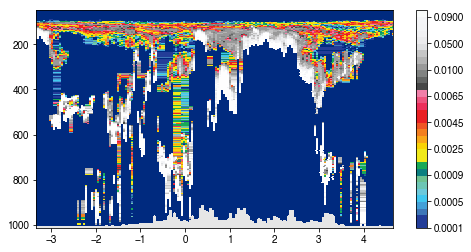

In [102]:
fig = mp.figure(figsize=(8,4))

ax = fig.add_subplot(111)
plot = ax.pcolormesh(lat_2d.T[::-1,:], p_data_subset.T[::-1,:], \
                     gdal_tbc_data_subset.T[::-1,:], norm=norm, cmap=calipso_colormap)

fig.colorbar(plot)

ax.set_facecolor('0.9')
ax.set_ylim(1013.25,50)

### interpolate

In [113]:
numpy.diff(p_data_subset)

array([[0.3422842 , 0.35168648, 0.36133862, ..., 0.        , 0.        ,
        0.        ],
       [0.3422861 , 0.35168648, 0.36133862, ..., 0.        , 0.        ,
        0.        ],
       [0.3422861 , 0.35168839, 0.36133957, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.3422594 , 0.35169983, 0.3613596 , ..., 0.        , 0.        ,
        0.        ],
       [0.34235477, 0.35180378, 0.36147118, ..., 0.        , 0.        ,
        0.        ],
       [0.34235382, 0.35180378, 0.36147022, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [110]:
print(numpy.diff(x))
numpy.diff(y)

0.0


array([0.3422842 , 0.35168648, 0.36133862, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

(1013.25, 50)

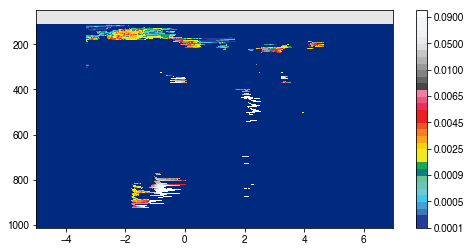

In [114]:
z = gdal_tbc_data_subset.ravel()
x = lat_2d.ravel()
#x = x[~numpy.isnan(z)]
y = p_data_subset.ravel()
#y = y[~numpy.isnan(z)]
#z = z[~numpy.isnan(z)]

xnew = numpy.arange(-5,7.01,0.04)
ynew = numpy.arange(113.25,1013.251,0.3)

znew = scipy.interpolate.griddata((x,y),z, (xnew[None,:],ynew[:,None]), method='linear')

fig = mp.figure(figsize=(8,4))
ax = fig.add_subplot(111)
plot = ax.pcolormesh(xnew,ynew,znew, norm=norm, cmap=calipso_colormap)

fig.colorbar(plot)

ax.set_facecolor('0.9')
ax.set_ylim(1013.25,50)

# loop through a few files and average their interpolation

In [105]:
et_file_list.shape

(248,)

In [106]:
# x (lat) and y (pressure) values to interpolate to
xnew = numpy.arange(-3.5,5.0001,0.01)
ynew = numpy.arange(113.25,1013.251,0.1)

nsteps = et_file_list.size
interpolated_fields = numpy.zeros((nsteps, ynew.size, xnew.size))

#for file in [et_file_list[0]]:
for f_idx in range(10):#range(nsteps):#[1,2,3]:#range(et_file_list.size):
    
    file = et_file_list[f_idx]
    print(file)
    
    ds = xarray.open_dataset(file)
    lon = ds['Longitude'].sel(fakeDim5=1).values
    lat = ds['Latitude'].sel(fakeDim3=1).values
    p_data = ds['Pressure'].values
    
    track_geom = shapely.geometry.LineString(zip(lon,lat))
    track_geom_crop = track_geom.intersection(borneo_main_geom)
    ds.close()

    # open stuff in gdal to get proper values...
    gdal_file = gdal.Open(file)
    gdal_subdatasets = gdal_file.GetSubDatasets()
    #gdal_clf_ds = gdal.Open(gdal_subdatasets[31][0]) # cloud fraction
    gdal_tbc_ds = gdal.Open(gdal_subdatasets[35][0]) # total backscatter coefficient
    #gdal_cmsp_ds = gdal.Open(gdal_subdatasets[43][0]) # Cloud_Multiple_Scattering_Profile_532

    gdal_tbc_data = gdal_tbc_ds.ReadAsArray()
    #gdal_clf_data = gdal_clf_ds.ReadAsArray()
    #gdal_cmsp_data = gdal_cmsp_ds.ReadAsArray()

    # get rid of -9999 and -3333 values
    gdal_tbc_data[gdal_tbc_data<0] = numpy.nan

    # crop stuff according to the geom_crop specification
    if type(track_geom_crop)==shapely.geometry.linestring.LineString:
        lon_crop,lat_crop = track_geom_crop.coords.xy
        lat_crop = numpy.array(lat_crop)
        lon_crop = numpy.array(lon_crop)
    elif type(track_geom_crop)==shapely.geometry.multilinestring.MultiLineString:
        #collect all x coords into array
        lon_crop = numpy.hstack( [linestring.coords.xy[0] for linestring in list(track_geom_crop)] )
        lat_crop = numpy.hstack( [linestring.coords.xy[1] for linestring in list(track_geom_crop)] )

    # get plaes where the crop is
    lon_left = lon_crop[0]
    lon_right = lon_crop[-1]
    lon_left_idx = numpy.abs(lon-lon_left).argmin()
    lon_right_idx = numpy.abs(lon-lon_right).argmin()
    
    # take subsets based on crop
    lon_subset = lon[lon_left_idx:lon_right_idx+1]
    lat_subset = lat[lon_left_idx:lon_right_idx+1]
    p_data_subset = p_data[lon_left_idx:lon_right_idx+1,:]
    lat_2d = numpy.repeat(lat_subset, p_data_subset.shape[1]).reshape((p_data_subset.shape))

    gdal_tbc_data_subset = gdal_tbc_data[lon_left_idx:lon_right_idx+1]
    #gdal_clf_data_subset = gdal_clf_data[lon_left_idx:lon_right_idx+1]
    #gdal_cmsp_data_subset = gdal_cmsp_data[lon_left_idx:lon_right_idx+1]
    
    z = gdal_tbc_data_subset.ravel()
    x = lat_2d.ravel()
    y = p_data_subset.ravel()
    xnew = numpy.arange(-3.5,5.0001,0.01)
    ynew = numpy.arange(113.25,1013.251,0.1)

    znew = scipy.interpolate.griddata((x,y),z, (xnew[None,:],ynew[:,None]), method='linear')
    interpolated_fields[f_idx,:,:] = znew

/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/CAL_LID_L2_05kmCPro-Standard-V4-10.2006-06-15T17-53-35ZN.hdf
/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/CAL_LID_L2_05kmCPro-Standard-V4-10.2006-07-01T17-53-31ZN.hdf
/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/CAL_LID_L2_05kmCPro-Standard-V4-10.2006-07-17T17-53-09ZN.hdf
/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/CAL_LID_L2_05kmCPro-Standard-V4-10.2006-08-02T17-52-33ZN.hdf
/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/CAL_LID_L2_05kmCPro-Standard-V4-10.2006-08-18T17-51-32ZN.hdf


KeyboardInterrupt: 

In [1]:
interpolated_fields_gt05 = numpy.copy(interpolated_fields)
interpolated_fields_gt05[interpolated_fields<0.05] = numpy.nan
mean = numpy.nanmean(interpolated_fields_gt05, axis=0)

NameError: name 'numpy' is not defined

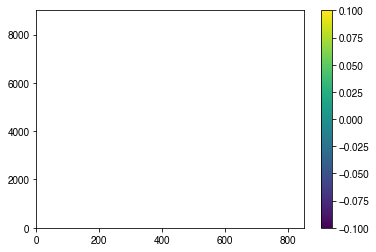

In [29]:
mp.pcolormesh(interpolated_fields_gt05[0,:,:]);mp.colorbar()

(1013.25, 50)

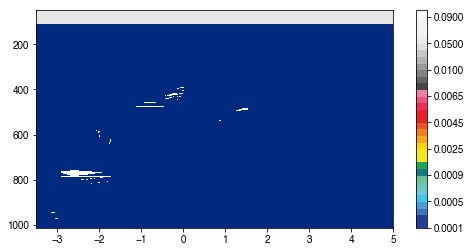

In [30]:
fig = mp.figure(figsize=(8,4))
ax = fig.add_subplot(111)
plot = ax.pcolormesh(xnew,ynew,mean,norm=norm,cmap=calipso_colormap)
fig.colorbar(plot)
ax.set_facecolor('0.9')
ax.set_ylim(1013.25,50)

In [85]:
interpolated_fields.shape

(248, 9001, 851)

In [86]:
first_half_mean = numpy.nanmean(interpolated_fields[:124,:,:], axis=0)
second_half_mean = numpy.nanmean(interpolated_fields[124:,:,:], axis=0)

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


(1013.25, 50)

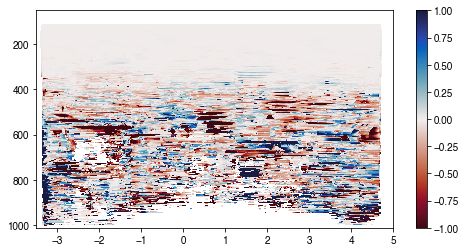

In [96]:
fig = mp.figure(figsize=(8,4))
ax = fig.add_subplot(111)
plot = ax.pcolormesh(xnew,ynew,second_half_mean-first_half_mean, vmin=-1, vmax=1, cmap=cmocean.cm.balance_r)
fig.colorbar(plot)
ax.set_facecolor('1')
ax.set_ylim(1013.25,50)

prep for linear regression

first:  pull out date information

In [68]:
date_list = [f.split('.')[-2][:-2] for f in et_file_list]
datetime_list = [datetime.datetime.strptime(t, '%Y-%m-%dT%H-%M-%S') for t in date_list]
timedelta_list = numpy.array([(t-datetime_list[0]).days for t in datetime_list])

takes about 2 hours to complete

In [82]:
rvals = numpy.zeros((ynew.size,xnew.size))*numpy.nan
pvals = numpy.zeros((ynew.size,xnew.size))*numpy.nan

for j in range(interpolated_fields.shape[1]):
    for k in range(interpolated_fields.shape[2]):
        not_nans = ~numpy.isnan(interpolated_fields[:,j,k])
        if sum(not_nans)>1:
            #print(not_nans)
            _,_,rvals[j,k],pvals[j,k],_ = scipy.stats.linregress(timedelta_list[not_nans], interpolated_fields[not_nans,j,k])

(1013.25, 50)

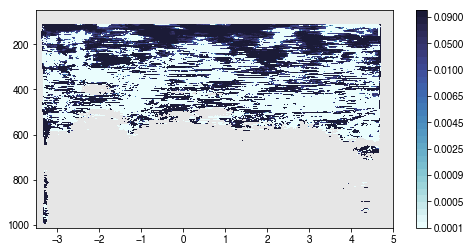

In [84]:
fig = mp.figure(figsize=(8,4))
ax = fig.add_subplot(111)
plot = ax.pcolormesh(xnew,ynew,rvals, norm=norm, cmap=cmap_partial)
fig.colorbar(plot)
ax.set_facecolor('0.9')
ax.set_ylim(1013.25,50)

(1013.25, 50)

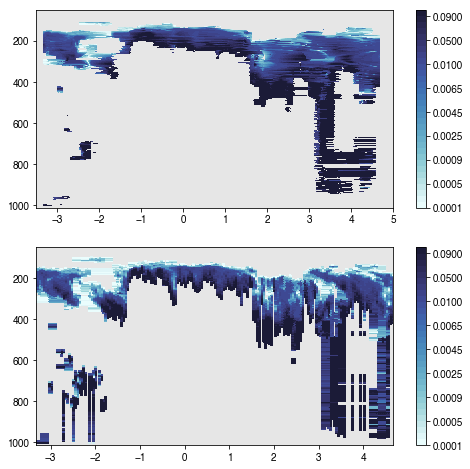

In [22]:
fig = mp.figure(figsize=(8,8))
ax = fig.add_subplot(211)
plot = ax.pcolormesh(xnew,ynew,interpolated_fields[0,:,:], norm=norm, cmap=cmap_partial)
fig.colorbar(plot)
ax.set_facecolor('0.9')
ax.set_ylim(1013.25,50)

ax = fig.add_subplot(212)
plot = ax.pcolormesh(lat_2d.T[::-1,:], p_data_subset.T[::-1,:], gdal_tbc_data_subset.T[::-1,:], norm=norm, cmap=cmap_partial)
fig.colorbar(plot)
ax.set_facecolor('0.9')
ax.set_ylim(1013.25,50)